Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import os
import shutil

# Check for GPU availability
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available.")
else:
    print("GPU is NOT available.")

GPU is NOT available.


Split to datasets

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Base path for Google Drive data
base_path = '/content/drive/MyDrive/data'

# Categories of images
categories = ['desert', 'green_area', 'water', 'cloudy']

# Ratios for splitting
train_ratio = 0.8

# Create directories for training and testing datasets if they don't already exist
train_path = os.path.join(base_path, 'training_set')
test_path = os.path.join(base_path, 'test_set')

if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

# For each category, split the data into training and testing
for category in categories:
    category_path = os.path.join(base_path, category)
    files = os.listdir(category_path)
    np.random.shuffle(files)  # Shuffle to randomize the files selected for testing

    # Split point
    split_point = int(len(files) * train_ratio)

    # Training and testing sets
    train_files = files[:split_point]
    test_files = files[split_point:]

    # Create category-specific directories in train and test folders
    train_category_path = os.path.join(train_path, category)
    test_category_path = os.path.join(test_path, category)

    if not os.path.exists(train_category_path):
        os.makedirs(train_category_path)
    if not os.path.exists(test_category_path):
        os.makedirs(test_category_path)

    # Move files to the respective directories
    for file in train_files:
        shutil.move(os.path.join(category_path, file), os.path.join(train_category_path, file))
    for file in test_files:
        shutil.move(os.path.join(category_path, file), os.path.join(test_category_path, file))

print("Data has been split into training and testing sets.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data has been split into training and testing sets.


In [ ]:
# Image dimensions and batch size
img_width, img_height = 255, 255
batch_size = 32

# Create image data generators for training and testing
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Random rotation within the range [-20, 20] degrees
    width_shift_range=0.1,  # Random horizontal shift by up to 10% of the width
    height_shift_range=0.1, # Random vertical shift by up to 10% of the height
    shear_range=0.2,        # Shear intensity (shear angle in counter-clockwise direction in radians)
    zoom_range=0.2,         # Random zoom up to 20%
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)

# Rescaling for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep data in the same order as the directory
)

# Define the CNN model
inputs = Input(shape=(255, 255, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
)

Found 4504 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.
Epoch 1/5
141/141 [==============================] - 1722s 12s/step - loss: 0.7431 - accuracy: 0.6241 - val_loss: 0.6528 - val_accuracy: 0.6406
Epoch 2/5
141/141 [==============================] - 1494s 11s/step - loss: 0.5342 - accuracy: 0.7003 - val_loss: 0.6137 - val_accuracy: 0.6974
Epoch 3/5
141/141 [==============================] - 1422s 10s/step - loss: 0.5507 - accuracy: 0.6994 - val_loss: 0.5993 - val_accuracy: 0.6637
Epoch 4/5
141/141 [==============================] - 1401s 10s/step - loss: 0.5307 - accuracy: 0.6985 - val_loss: 0.4534 - val_accuracy: 0.7587
Epoch 5/5
141/141 [==============================] - 1403s 10s/step - loss: 0.5206 - accuracy: 0.7094 - val_loss: 0.4691 - val_accuracy: 0.7436


## Save & Load Model

In [28]:
from tensorflow.keras.models import load_model
# Save the model as an h5 file
model.save('Model.h5')

# Load the model
model = load_model('Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Summary

In [29]:
# Display the model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 253, 253, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 251, 251, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 125, 125, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                     

## Evaluate the model

In [30]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

36/36 - 89s - loss: 0.4691 - accuracy: 0.7436 - 89s/epoch - 2s/step
Test accuracy: 0.74


## Predict on the test data

36/36 [==============================] - 130s 4s/step
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.92      0.81      0.86       300
      Desert       0.81      0.97      0.88       227
  Green_Area       0.59      0.99      0.74       300
       Water       0.91      0.26      0.40       300

    accuracy                           0.74      1127
   macro avg       0.81      0.76      0.72      1127
weighted avg       0.81      0.74      0.71      1127



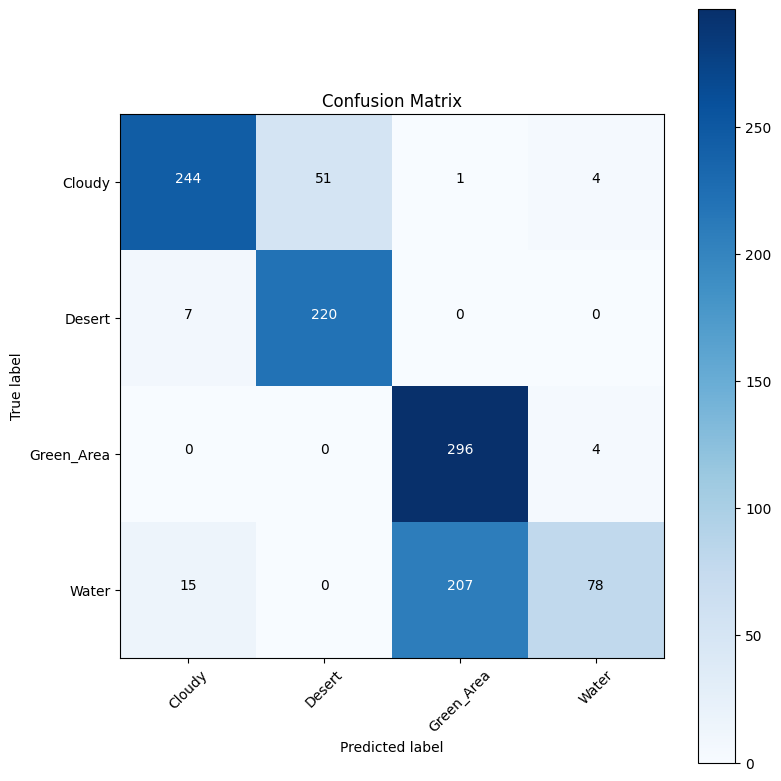

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools


# Get the model predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


# Classification report
target_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']  # Ensure this matches your categories
print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Add values to the plot
threshold = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()